## MesoSim NAV file processing with Q-API

## Initial setup

In [ ]:
!pip install requests==2.31.0
!pip install matplotlib==3.7.1
!pip install seaborn==0.13.1
!pip install pandas_datareader==0.10.0

In [1]:
import csv
import json
import time
import multiprocessing
import random
import numpy
import datetime
from io import StringIO
from os import listdir

from dateutil.parser import parse as dateparser

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt3
import seaborn as sns
import matplotlib.pyplot as plt

import pandas_datareader.data as web
from IPython.core.display import display, HTML
import requests
from urllib3.util import Retry
from requests.adapters import HTTPAdapter

In [8]:
Q_API_INSTANCE="q-api.deltaray.io"

In [4]:
http_client = requests.Session()

http_retries = Retry(
    total=5,
    backoff_factor=0.1,
    status_forcelist=[500, 502, 503, 504, 520]
)
http_client.mount('https://', HTTPAdapter(max_retries=http_retries, pool_connections=50, pool_maxsize=50))


def load_backtest_nav(filename):
    with open(filename, 'r') as f:
      content = f.readlines()

      nav_values = {"SimTime": [], "NAV": []}
      nav_csv_reader = csv.DictReader(content)
      for row in nav_csv_reader:
        nav_values["SimTime"].append(dateparser(row["Sim Time"]))
        nav_values["NAV"].append(float(row["NAV"]))

    return nav_values

def _q_api_df_to_csv(df, colname):
  result_df = df.resample('D').ffill()      # Have one reading per day
  result_df = result_df[[colname]]          # Keep sum only
  result_df.rename(columns={colname: "StrategyNAV"}, inplace=True)
  result_df.index.rename('DateTime', inplace=True)


  df_spx = web.DataReader(
        '^SPX', 'stooq',
        result_df.index[0].date(), result_df.index[-1].date())
  result_df["BenchmarkPrice"] = df_spx["Close"]

  result_df.dropna(inplace=True)

  result_csv = result_df.to_csv()
  return result_csv


def display_tearsheet(q_api_instance, df, colname):
  my_csv = _q_api_df_to_csv(df, colname)
  url = f"https://{q_api_instance}/quantstats/v1/tearsheet-from-csv"
  resp = http_client.post(url, data=my_csv,
                          headers = {'Content-Type': 'text/plain'})
  resp.raise_for_status()
  display(HTML(resp.content.decode('utf-8')))

def get_metrics(q_api_instance, df, colname):
  my_csv = _q_api_df_to_csv(df, colname)
  url = f"https://{q_api_instance}/quantstats/v1/metrics-from-csv"
  resp = http_client.post(url, data=my_csv,
                          headers = {'Content-Type': 'text/plain'})
  resp.raise_for_status()
  return resp.json()

def walkforward_metrics(q_api_instance, df, optMode, topAlloc, window):
  df_copy = pd.DataFrame(df)
  df_copy.index.rename('DateTime', inplace=True)
  my_csv = df_copy.to_csv()
  url = f"https://{q_api_instance}/portfolio-optimizer/v1/walkforward-portfolio?mode={optMode}&topAlloc={topAlloc}&windowSize={window}"
  resp = http_client.post(url, data=my_csv,
                          headers = {'Content-Type': 'text/plain'})
  resp.raise_for_status()
  result_df = pd.read_csv(StringIO(resp.content.decode('utf-8')), parse_dates=True, index_col='DateTime')
  metrics = get_metrics(q_api_instance, api_key, result_df, 'portfolio')
  return metrics

def walkforward_tearsheet(q_api_instance, df, optMode, topAlloc, window):
  df_copy = pd.DataFrame(df)
  df_copy.index.rename('DateTime', inplace=True)
  my_csv = df_copy.to_csv()
  url = f"https://{q_api_instance}/portfolio-optimizer/v1/walkforward-portfolio?mode={optMode}&topAlloc={topAlloc}&windowSize={window}"
  resp = http_client.post(url, data=my_csv,
                          headers = {'Content-Type': 'text/plain'})
  resp.raise_for_status()
  result_df = pd.read_csv(StringIO(resp.content.decode('utf-8')), parse_dates=True, index_col='DateTime')
  tearsheet = display_tearsheet(q_api_instance, api_key, result_df, 'portfolio')

def optimized_metrics(q_api_instance, df, optMode, topAlloc):
  df_copy = pd.DataFrame(df)
  df_copy.index.rename('DateTime', inplace=True)
  my_csv = df_copy.to_csv()
  url = f"https://{q_api_instance}/portfolio-optimizer/v1/optimize-portfolio?mode={optMode}&topAlloc={topAlloc}&windowSize={window}"
  resp = http_client.post(url, data=my_csv,
                          headers = {'Content-Type': 'text/plain'})
  resp.raise_for_status()
  result_df = pd.read_csv(StringIO(resp.content.decode('utf-8')), parse_dates=True, index_col='DateTime')
  metrics = get_metrics(q_api_instance, api_key, result_df, 'portfolio')
  return metrics

## Download NAV Exports from MesoSim:
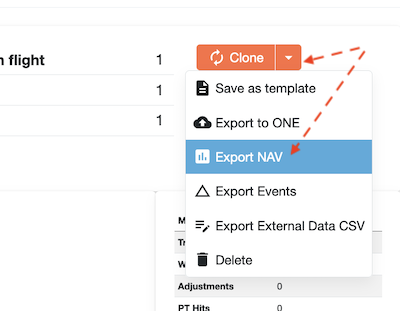

## Upload obtained NAV Exports to the Notebook
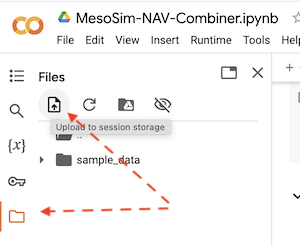

## Specify the uploaded file's name (or full path)

In [3]:
nav_files = {
    "quantpedia-seasonality": "mesosim-Portfolio-Opt.QuantPedia-SeasonalityIndex-VRP-compounding-240630_175001.nav.csv",
    "45dte-short-put-trailingstop": "mesosim-Portfolio-Opt.45DTE-ShortPut-TrailingStop-compounding-240701_033605.nav.csv"
}

## Load all the NAV files into a DataFrame

In [5]:
def merge_dfs(dfs):
    result = dfs[0]
    for i, df in enumerate(dfs[1:], 2):
        result = pd.merge(result, df, on='SimTime', how='outer', suffixes=('', f'_df{i}'))
    return result

mc_dfs = []
for (name, filename) in nav_files.items():
  result = load_backtest_nav(filename)
  result[name] = result.pop("NAV")
  df = pd.DataFrame(result)
  mc_dfs.append(df)

merged_df = merge_dfs(mc_dfs)
merged_df = merged_df.dropna()
merged_df.set_index('SimTime', inplace=True)

## Show the correlation of the NAVs

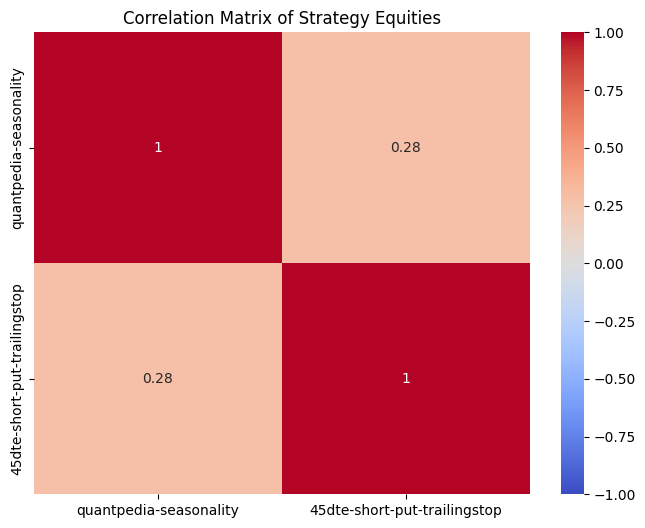

In [6]:
log_rets = np.log(merged_df).diff().dropna()
correlation_matrix = log_rets.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Strategy Equities')
plt.show()


## Create Equal Allocation portfolio and display Tearsheet

In [10]:
total_capital = 100000
num_assets = len(merged_df.columns)
equal_allocation = total_capital / num_assets
portfolio = equal_allocation * merged_df


summed = pd.DataFrame(portfolio)
summed["sum"] = summed.sum(axis=1)


display_tearsheet(Q_API_INSTANCE, summed, 'sum')